In [1]:
from glob import glob
from typing import List

import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import tensorflow as tf
from sklearn.model_selection import train_test_split

import spectrum_painting as sp
import spectrum_painting_model as sp_model
import spectrum_painting_plotting as sp_plot
import spectrum_painting_predict as sp_predict
import spectrum_painting_training as sp_training
from spectrum_painting_training import SpectrumPaintingTrainTestSets

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


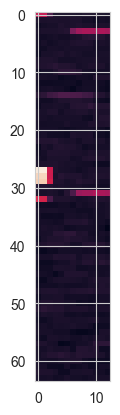

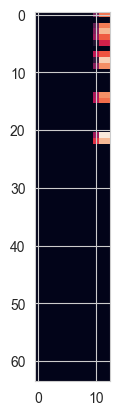

Number of training images: 2412
Number of testing images: 1034


In [7]:
classes = ["Z", "B", "W", "BW", "ZB", "ZW", "ZBW"]

label_names: List[str] = []
labels: List[int] = []
augmented_images: List[npt.NDArray[np.uint8]] = []
painted_images: List[npt.NDArray[np.uint8]] = []

options = sp_training.SpectrumPaintingTrainingOptions(
    downsample_resolution=64,
    k=3,
    l=16,
    d=4
)

for label_index, c in enumerate(classes):
    label_names.append(c)

    for f in glob(f"data/testbed/{c}/*"):
        image = imageio.imread(f)
        # image = image[64:]
        image = image.T

        downsampled = sp.downsample_spectrogram(image, options.downsample_resolution)
        # downsampled = sp.digitize_spectrogram(downsampled)

        augmented = sp.augment_spectrogram(downsampled, options.k, options.l, options.d)
        augmented = sp.digitize_spectrogram(augmented)

        painted = sp.paint_spectrogram(downsampled, augmented)
        painted = sp.digitize_spectrogram(painted)

        labels.append(label_index)
        augmented_images.append(augmented)
        painted_images.append(painted)

x_combined = np.stack((augmented_images, painted_images), axis=3)

test_size = 0.3

x_train, x_test, labels_train, labels_test = train_test_split(x_combined,
                                                              labels,
                                                              test_size=test_size)

# for tensorflow it must be uint8 and not a Python int.
y_train = labels_train
y_train = np.asarray(y_train, dtype=np.uint8)

y_test = labels_test
y_test = np.asarray(y_test, dtype=np.uint8)

x_train_augmented = x_train[:, :, :, 0]
x_test_augmented = x_test[:, :, :, 0]

x_train_painted = x_train[:, :, :, 1]
x_test_painted = x_test[:, :, :, 1]

image_index = 0

plt.imshow(x_train_augmented[image_index])
plt.show()

plt.imshow(x_test_painted[image_index])
plt.show()

print(f"Number of training images: {len(y_train)}")
print(f"Number of testing images: {len(y_test)}")

train_test_sets = SpectrumPaintingTrainTestSets(
    x_train_augmented,
    x_train_painted,
    y_train,
    [0],
    x_test_augmented,
    x_test_painted,
    y_test,
    [0],
    label_names,
)

2024-06-19 00:29:46.259273: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-06-19 00:29:46.259294: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-06-19 00:29:46.259300: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-06-19 00:29:46.259331: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-19 00:29:46.259345: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-06-19 00:29:46.694108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 Epoch: 178, Val. accuracy = 0.7388781309127808

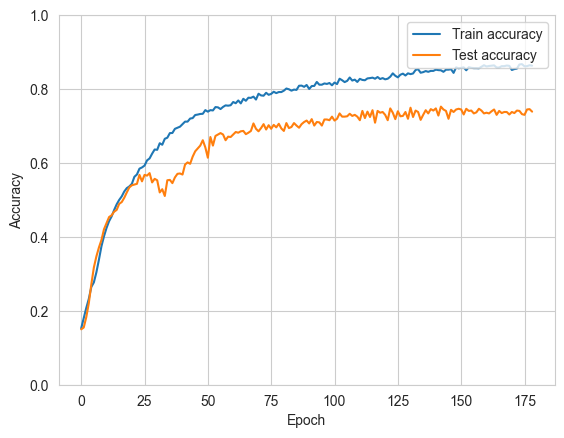

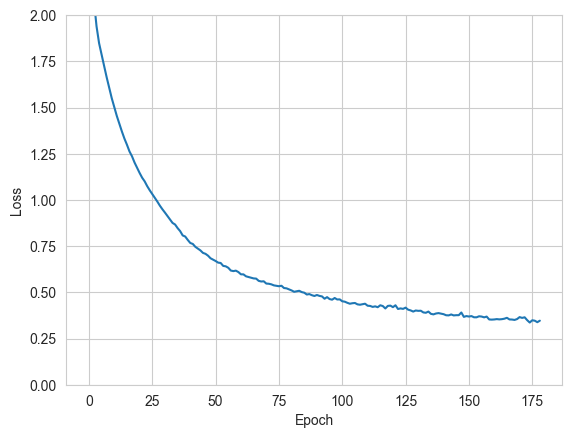

In [4]:
image_shape = train_test_sets.x_train_augmented[0].shape

full_model = sp_model.create_tensorflow_model(image_shape=image_shape,
                                              label_count=len(train_test_sets.label_names))

history = sp_model.fit_model(full_model, train_test_sets, epochs=300, early_stopping_patience=20)

sp_plot.plot_model_accuracy_epochs(history)
sp_plot.plot_model_loss(history)

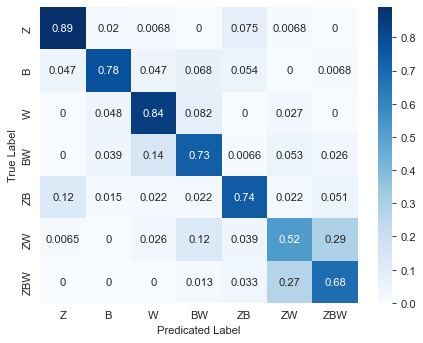

In [5]:
full_model_y_predictions = [sp_predict.predict_full_model(full_model, x_a, x_p) for (x_a, x_p) in
                            zip(train_test_sets.x_test_augmented, train_test_sets.x_test_painted)]

sp_plot.plot_confusion_matrix(full_model_y_predictions, train_test_sets.y_test, train_test_sets.label_names)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


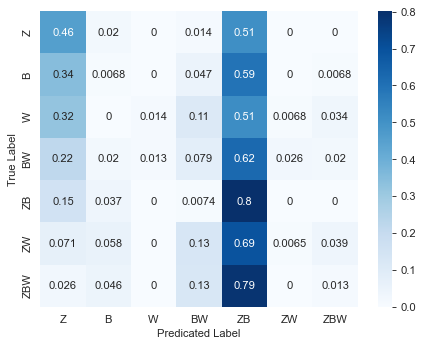

In [6]:
tflite_model: List[bytes]

with open("output/spectrum-painting-model-10-iterations.tflite", "rb") as f:
    tflite_model = f.read()

# interpreter = tf.lite.Interpreter(model_content=tflite_model)
# interpreter.allocate_tensors()

full_model_y_predictions = [sp_predict.predict_lite_model(tflite_model, x_a, x_p) for (x_a, x_p) in
                            zip(train_test_sets.x_test_augmented, train_test_sets.x_test_painted)]

sp_plot.plot_confusion_matrix(full_model_y_predictions, train_test_sets.y_test, train_test_sets.label_names)